In [27]:
import pandas as pd
import yfinance as yf
import numpy as np

 

# Define the list of Forex symbols you want to download
symbols = ['USDMYR=X', 'USDCNY=X']

 

# Define the start and end dates for the data
start_date = '2013-01-01'
end_date = '2023-07-31'

 

# Download the Forex data using yfinance
forex_data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

 

# Create a DataFrame from the downloaded data
df = pd.DataFrame(forex_data)
df_ma= df.rolling(window=3).mean()

df=df.reset_index()
df_ma=df_ma.reset_index()

 
df.head()

[*********************100%***********************]  2 of 2 completed


,Date,USDCNY=X,USDMYR=X
0,2013-01-01,6.2306,3.0544
1,2013-01-02,6.2376,3.0304
2,2013-01-03,6.2332,3.0350
3,2013-01-04,6.2325,3.0457
4,2013-01-07,6.2305,3.0396


In [28]:
df.to_excel(r'\\10.186.237.122\grcm\GCRM-GEN\GCCRM\Group Corporate Credit Risk\Pet Project\VECM\corr6.xlsx', index=False)

In [29]:
df.columns = ['Date', 'USDCNY', 'USDMYR']
df_ma.columns = ['Date', 'USDCNY', 'USDMYR']

In [30]:

from pandasql import sqldf

check_df=sqldf("""Select * 
                  from df where USDCNY is null or USDMYR is null""")
check_df.head()

,Date,USDCNY,USDMYR
0,2013-10-08 00:00:00.000000,None,3.1938
1,2017-07-11 00:00:00.000000,None,4.2950
2,2017-11-16 00:00:00.000000,None,4.1691


In [31]:
null_rows = df[df.isnull().any(axis=1)]
null_rows

,Date,USDCNY,USDMYR
200,2013-10-08,NaN,3.1938
1180,2017-07-11,NaN,4.2950
1272,2017-11-16,NaN,4.1691


In [32]:

df2=sqldf("""Select * 
              from df 
              where USDCNY is not null and USDMYR is not null """)

df2_ma =sqldf("""Select * 
                  from df_ma 
                  where USDCNY is not null and USDMYR is not null """)



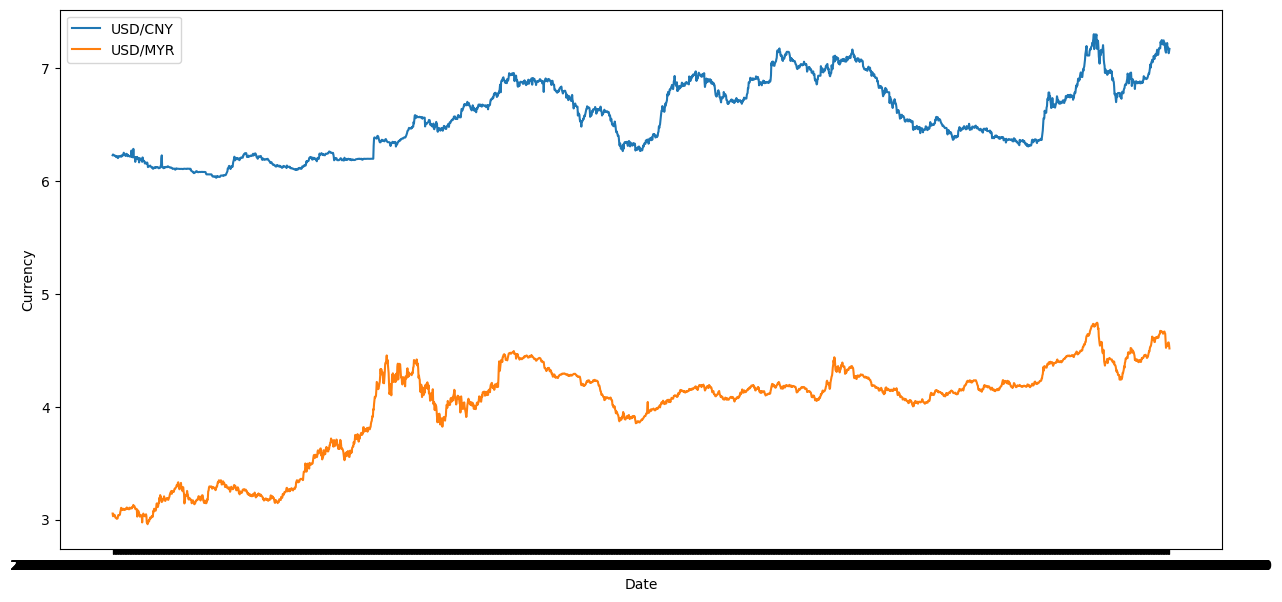

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15, 7))

# Create line chart
plt.plot(df2['Date'], df2['USDCNY'], label='USD/CNY')
plt.plot(df2['Date'], df2['USDMYR'], label='USD/MYR')




# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Currency')

plt.legend()

# Display the chart
plt.show()

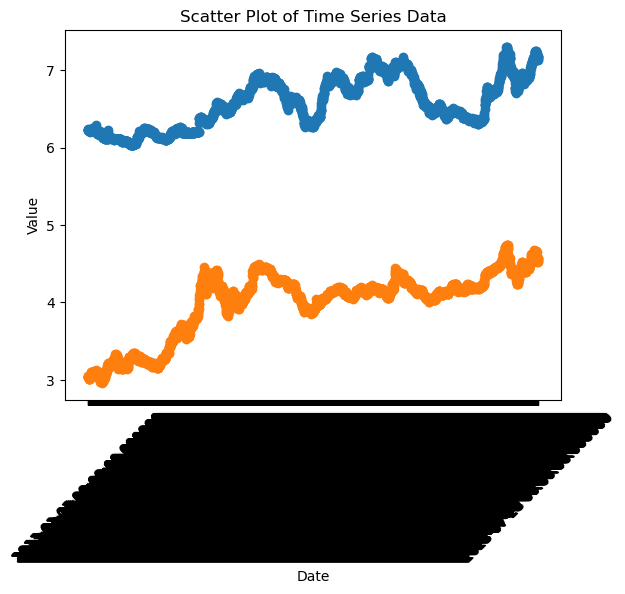

In [11]:
plt.scatter(df2['Date'], df2['USDCNY'], label='USD/CNY')
plt.scatter(df2['Date'], df2['USDMYR'], label='USD/MYR')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Scatter Plot of Time Series Data')

# Rotate the date labels on the x-axis for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [26]:
df2_ma.to_excel(r'\\10.186.237.122\grcm\GCRM-GEN\GCCRM\Group Corporate Credit Risk\Pet Project\VECM\corr7.xlsx', index=False)

In [33]:
df3 = df2.drop(columns='Date')
df3_ma = df2_ma.drop(columns='Date')

In [34]:
df3_corr = df3.corr()
df3_ma_corr = df3_ma.corr()

print(df3_corr)
print(df3_ma_corr)

         USDCNY   USDMYR
USDCNY  1.00000  0.80077
USDMYR  0.80077  1.00000
          USDCNY    USDMYR
USDCNY  1.000000  0.800904
USDMYR  0.800904  1.000000


In [35]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(df3[['USDCNY']], df3[['USDMYR']])
r_squared = lm.score(df3[['USDCNY']], df3[['USDMYR']])

lm2 = LinearRegression()
lm2.fit(df3_ma[['USDCNY']], df3_ma[['USDMYR']])
r_squared_ma = lm.score(df3_ma[['USDCNY']], df3_ma[['USDMYR']])

print(r_squared)
print(r_squared_ma)

0.641233245571037
0.6414466220025841


In [36]:
print(f"Intercept_lm => {lm.intercept_}")
print(f"coefficient_lm => {lm.coef_}")
print(f"Intercept_lm2 => {lm2.intercept_}")
print(f"coefficient_lm2 => {lm2.coef_}")

Intercept_lm => [-2.96666398]
coefficient_lm => [[1.05799689]]
Intercept_lm2 => [-2.96243034]
coefficient_lm2 => [[1.05740554]]


In [46]:
# Calculate the number of data points
num_data_points = df3[['USDCNY']].shape[0]
num_data_points_ma = df3_ma[['USDMYR']].shape[0]
print(num_data_points)
print(num_data_points_ma)

2754
2746


In [47]:
num_predictors = df3[['USDCNY']].shape[1]
num_predictors_ma = df3_ma[['USDCNY']].shape[1]
print(num_predictors)
print(num_predictors_ma)


1
1


In [39]:
adjusted_r_squared = 1 - (1 - r_squared) * ((num_data_points - 1) / (num_data_points - num_predictors - 1))
adjusted_r_squared_ma = 1 - (1 - r_squared_ma) * ((num_data_points_ma - 1) / (num_data_points_ma - num_predictors_ma - 1))
print(adjusted_r_squared)
print(adjusted_r_squared_ma)

0.641102879744573
0.6413159538619144


In [40]:
df4 = sqldf("""select *,
                case when Date < '2018-01-01' then 0 else 1 end as X2
                from df2
              """)
df4_ma = sqldf("""select *,
                case when Date < '2018-01-01' then 0 else 1 end as X2
                from df2_ma
              """)
df4_ma

,Date,USDCNY,USDMYR,X2
0,2013-01-03 00:00:00.000000,6.233800,3.039933,0
1,2013-01-04 00:00:00.000000,6.234433,3.037033,0
2,2013-01-07 00:00:00.000000,6.232067,3.040100,0
3,2013-01-08 00:00:00.000000,6.230934,3.042500,0
4,2013-01-09 00:00:00.000000,6.228167,3.039367,0
...,...,...,...,...
2741,2023-07-24 00:00:00.000000,7.193433,4.547833,1
2742,2023-07-25 00:00:00.000000,7.179900,4.558167,1
2743,2023-07-26 00:00:00.000000,7.166200,4.568500,1
2744,2023-07-27 00:00:00.000000,7.156900,4.564000,1


In [41]:

lm_multi = LinearRegression()
lm_multi.fit(df4[['USDCNY','X2']], df4[['USDMYR']])
r_squared_multi = lm_multi.score(df4[['USDCNY','X2']], df4[['USDMYR']])

lm_multi_ma = LinearRegression()
lm_multi_ma.fit(df4_ma[['USDCNY','X2']], df4_ma[['USDMYR']])
r_squared_multi_ma = lm_multi.score(df4_ma[['USDCNY','X2']], df4_ma[['USDMYR']])

adjusted_r_squared_multi = 1 - (1 - r_squared_multi) * ((num_data_points - 1) / (num_data_points - num_predictors - 1))
adjusted_r_squared_multi_ma = 1 - (1 - r_squared_multi_ma) * ((num_data_points_ma - 1) / (num_data_points_ma - num_predictors_ma - 1))

print(f"r_squared_multi = {r_squared_multi}")
print(f"r_squared_multi_ma = {r_squared_multi_ma}")
print(f"adjusted_r_squared_multi = {adjusted_r_squared_multi}")
print(f"adjusted_r_squared_multi_ma = {adjusted_r_squared_multi_ma}")

r_squared_multi = 0.6564312024387688
r_squared_multi_ma = 0.6567215665251944
adjusted_r_squared_multi = 0.6563063591257016
adjusted_r_squared_multi_ma = 0.6565964650552691


In [42]:
print(f"Intercept_lm_multi => {lm_multi.intercept_}")
print(f"coefficient_lm_multi => {lm_multi.coef_}")
print(f"Intercept_lm_multi_ma => {lm_multi_ma.intercept_}")
print(f"coefficient_lm_multi_ma => {lm_multi_ma.coef_}")

Intercept_lm_multi => [-2.34133678]
coefficient_lm_multi => [[0.95280537 0.12635073]]
Intercept_lm_multi_ma => [-2.33506451]
coefficient_lm_multi_ma => [[0.95185978 0.1265445 ]]


In [43]:
predicted_values = lm_multi.predict(df4[['USDCNY','X2']])
df4['Predicted_value'] = predicted_values

predicted_values_ma = lm_multi_ma.predict(df4_ma[['USDCNY','X2']])
df4_ma['Predicted_value'] = predicted_values_ma
df4_ma

,Date,USDCNY,USDMYR,X2,Predicted_value
0,2013-01-03 00:00:00.000000,6.233800,3.039933,0,3.598639
1,2013-01-04 00:00:00.000000,6.234433,3.037033,0,3.599242
2,2013-01-07 00:00:00.000000,6.232067,3.040100,0,3.596989
3,2013-01-08 00:00:00.000000,6.230934,3.042500,0,3.595911
4,2013-01-09 00:00:00.000000,6.228167,3.039367,0,3.593277
...,...,...,...,...,...
2741,2023-07-24 00:00:00.000000,7.193433,4.547833,1,4.638620
2742,2023-07-25 00:00:00.000000,7.179900,4.558167,1,4.625738
2743,2023-07-26 00:00:00.000000,7.166200,4.568500,1,4.612697
2744,2023-07-27 00:00:00.000000,7.156900,4.564000,1,4.603845


In [44]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(df4[['USDMYR']],df4[['Predicted_value']] )
rmse = np.sqrt(mse)

mse_ma = mean_squared_error(df4_ma[['USDMYR']],df4_ma[['Predicted_value']] )
rmse_ma = np.sqrt(mse_ma)

mean = df4['USDMYR'].mean()
mean_ma = df4_ma['USDMYR'].mean()

#scatter Index
SI = rmse/mean * 100
SI_ma = rmse_ma/mean_ma * 100

print(f"RMSE => {rmse}")
print(f"RMSE_ma => {rmse_ma}")
print(f"SI => {SI}")
print(f"SI_ma => {SI_ma}")


RMSE => 0.2519426657090663
RMSE_ma => 0.2514279450457748
SI => 6.309233574564829
SI_ma => 6.295722371833011


In [24]:
# from sklearn import metrics

# print('MAE:', metrics.mean_absolute_error(y_test, predictions))
# print('MSE:', metrics.mean_squared_error(y_test, predictions))
# print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

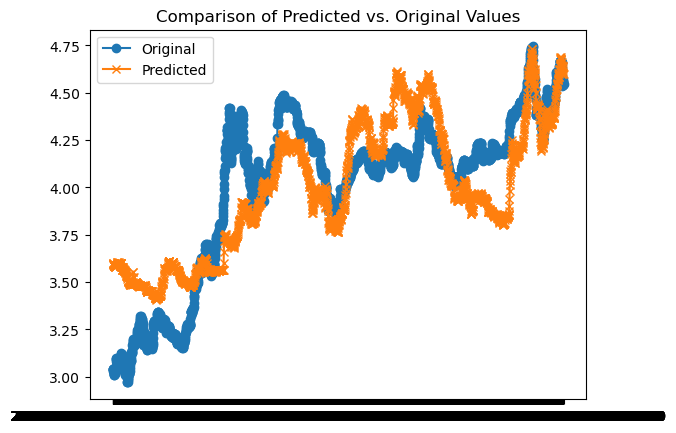

In [25]:
plt.plot(df4_ma['Date'], df4_ma['USDMYR'], label='Original', marker='o')
plt.plot(df4_ma['Date'], df4_ma['Predicted_value'], label='Predicted', marker='x')

plt.title('Comparison of Predicted vs. Original Values')
plt.legend()
plt.show()

In [154]:
# from sklearn.linear_model import LinearRegression
# lm = LinearRegression()
# lm.fit(X_train,y_train)

LinearRegression()

In [45]:

df_eco = sqldf("""select *,
              
                case when Date < '2018-01-01' then 0 else 1 end as Dummy
                from df2_ma
              """)

df2_eco = sqldf("""select *,
                 USDCNY*Dummy as DX
                from df_eco
              """)
df2_eco

,Date,USDCNY,USDMYR,Dummy,DX
0,2013-01-03 00:00:00.000000,6.233800,3.039933,0,0.000000
1,2013-01-04 00:00:00.000000,6.234433,3.037033,0,0.000000
2,2013-01-07 00:00:00.000000,6.232067,3.040100,0,0.000000
3,2013-01-08 00:00:00.000000,6.230934,3.042500,0,0.000000
4,2013-01-09 00:00:00.000000,6.228167,3.039367,0,0.000000
...,...,...,...,...,...
2741,2023-07-24 00:00:00.000000,7.193433,4.547833,1,7.193433
2742,2023-07-25 00:00:00.000000,7.179900,4.558167,1,7.179900
2743,2023-07-26 00:00:00.000000,7.166200,4.568500,1,7.166200
2744,2023-07-27 00:00:00.000000,7.156900,4.564000,1,7.156900


In [48]:
lm_eco = LinearRegression()
lm_eco.fit(df2_eco[['USDCNY','Dummy','DX']], df2_eco[['USDMYR']])
r_squared_eco = lm_eco.score(df2_eco[['USDCNY','Dummy','DX']], df2_eco[['USDMYR']])

num_X_eco = df2_eco[['USDCNY']].shape[0]
num_Y_eco = df2_eco[['USDMYR']].shape[1]
adjusted_r_squared_eco = 1 - (1 - r_squared_eco) * ((num_X_eco  - 1) / (num_X_eco  - num_Y_eco  - 1))

print(f"r_squared_eco = {r_squared_eco}")
print(f"adjusted_r_squared_eco = {adjusted_r_squared_eco}")

print(f"Intercept_eco => {lm_eco.intercept_}")
print(f"coefficient_eco => {lm_eco.coef_}")

r_squared_eco = 0.7949072864984388
adjusted_r_squared_eco = 0.794832544255909
Intercept_eco => [-6.26024946]
coefficient_eco => [[ 1.56600602  7.8039532  -1.17044715]]


In [51]:
predicted_values_eco = lm_eco.predict(df2_eco[['USDCNY','Dummy','DX']])
df2_eco['Predicted_value'] = predicted_values_eco
df2_eco

,Date,USDCNY,USDMYR,Dummy,DX,Predicted_value
0,2013-01-03 00:00:00.000000,6.233800,3.039933,0,0.000000,3.501919
1,2013-01-04 00:00:00.000000,6.234433,3.037033,0,0.000000,3.502911
2,2013-01-07 00:00:00.000000,6.232067,3.040100,0,0.000000,3.499205
3,2013-01-08 00:00:00.000000,6.230934,3.042500,0,0.000000,3.497430
4,2013-01-09 00:00:00.000000,6.228167,3.039367,0,0.000000,3.493097
...,...,...,...,...,...,...
2741,2023-07-24 00:00:00.000000,7.193433,4.547833,1,7.193433,4.389130
2742,2023-07-25 00:00:00.000000,7.179900,4.558167,1,7.179900,4.383777
2743,2023-07-26 00:00:00.000000,7.166200,4.568500,1,7.166200,4.378358
2744,2023-07-27 00:00:00.000000,7.156900,4.564000,1,7.156900,4.374679


In [50]:




from sklearn.metrics import mean_squared_error

mse_eco = mean_squared_error(df2_eco[['USDMYR']],df2_eco[['Predicted_value']] )
rmse_eco = np.sqrt(mse_eco)

mean_eco = df2_eco['USDMYR'].mean()


#scatter Index
SI_eco = rmse_eco/mean_eco * 100


print(f"RMSE_eco => {rmse_eco}")
print(f"SI_eco => {SI_eco}")



RMSE_eco => 0.1943415799419215
SI_eco => 4.866287366724392


In [ ]:
from chow_test import chow_test

x_chow=df2_eco['USDCNY=X'].squeeze()
y_chow=df2_eco['USDMYR=X'].squeeze()

chow_test(y_series=y_chow, X_series=x_chow,
         last_index=1378,
         first_index=1379,
         significance=.05)

## Regression Evaluation Metrics


Here are three common evaluation metrics for regression problems:

**Mean Absolute Error** (MAE) is the mean of the absolute value of the errors:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

**Mean Squared Error** (MSE) is the mean of the squared errors:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

**Root Mean Squared Error** (RMSE) is the square root of the mean of the squared errors:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparing these metrics:

- **MAE** is the easiest to understand, because it's the average error.
- **MSE** is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
- **RMSE** is even more popular than MSE, because RMSE is interpretable in the "y" units.


In [ ]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")
        
# ADF Test on each column
for name, column in check_df.iteritems():
    adfuller_test(column, name=column.name)
    print()